## CpE 520 Project - David Babalola & Samuel Olugbemi
> This notebook includes code for our term project for **CpE 520, Application of Neural Networks**, at West Virginia University

___

The aim of this project is to train a CNN model for emotion recognition.

I will be using the dataset provided by Jonathan Oheix (from the FER2013) on Kaggle (find it [here](https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset/data)) to train and test the model.

Additionally, I will be testing the model on two datasets:

<ol>
<li>The Extended Cohn–Kanade (CK+) database [1]</li>
<li>Japanese Female Facial Expressions (JAFFE) database [2]</li>
</ol>

**References**

[1]	P. Lucey, J. F. Cohn, T. Kanade, J. Saragih, Z. Ambadar, and I. Matthews, “The Extended Cohn-Kanade Dataset (CK+): A complete dataset for action unit and emotion-specified expression,” in 2010 IEEE Computer Society Conference on Computer Vision and Pattern Recognition - Workshops, San Francisco, CA, USA: IEEE, Jun. 2010, pp. 94–101. doi: 10.1109/CVPRW.2010.5543262.

[2]	M. J. Lyons, J. Budynek, and S. Akamatsu, “Automatic classification of single facial images,” IEEE Trans. Pattern Anal. Machine Intell., vol. 21, no. 12, pp. 1357–1362, Dec. 1999, doi: 10.1109/34.817413.



### Importing the Libraries

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import torchvision.transforms as T
from torchvision import models
from torchvision import datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.__version__

'2.5.1'

### GPU Set Up

### Part 1 Data Preprocessing

#### Configuration

In [31]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#DEVICE = 'cpu'

In [4]:
DEVICE

device(type='cuda')

#### Training Set: Jonathan Oheix
Emotions
> angry, disgust, fear, happy, neutral, sad, surprise


In [32]:
BATCH_SIZE = 128

In [33]:
# Images are already in 48 X 48, so no need to resize
training_augs = T.Compose([
    T.Grayscale(num_output_channels=3),
    T.Resize((48, 48)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize with mean=0.5 and std=0.5 (adjust for specific needs)
    T.RandomHorizontalFlip(),
    T.RandomAffine(degrees=0, shear=0.2, scale=(0.8, 1.2))
])


training_set = datasets.ImageFolder(root='jonathan_oheix/train', transform=training_augs)

training_loader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)

#### Testing Set: Jonathan Oheix

In [34]:
valid_augs = T.Compose([
    T.Grayscale(num_output_channels=3),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_set = datasets.ImageFolder(root='jonathan_oheix/validation', transform=valid_augs)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

##### Dataset shape

In [35]:
# Print shape of training and testing images
print(f"Training set: {len(training_set)} images")
print(f"Testing set: {len(test_set)} images")

for images, labels in training_loader:
  break

print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

Training set: 28821 images
Testing set: 7066 images
One image batch shape : torch.Size([128, 3, 48, 48])
One label batch shape : torch.Size([128])


In [36]:
print(training_set.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


##### Print sample image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..1.0].


Text(0.5, 1.0, '0')

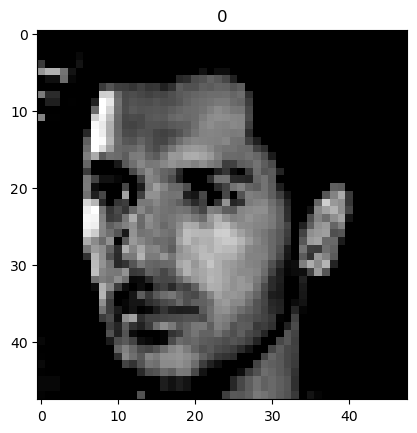

In [37]:
image, label = training_set[150]
plt.imshow(image.permute(1, 2, 0)) # Original should be (h, w, c). Transformation changes it to (c, h, w) 
plt.title(label)

### Part 2 - Building the CNN

#### Initializing the CNN

In [ ]:
class EmotionClassifier(nn.Module):
    def __init__(self, params):
        super(EmotionClassifier, self).__init__()
        num_classes = params['num_classes']

        # First convolutional layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # Output: 32x24x24
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected (dense) layers
        self.fc1 = nn.Linear(in_features=512*3*3, out_features=1024)
        self.dropout = nn.Dropout2d(params['dropout_rate'])
        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=num_classes)
       
        #self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        output = self.layer1(x)  # Pass through first layer
        output = self.layer2(output)  # Pass through second layer
        output = self.layer3(output)  # Pass through third layer
        output = self.layer4(output)  # Pass through fourth layer
        output = self.layer5(output)  # Pass through fifth layer
        output = output.view(output.size(0), -1)  # Flatten for the fully connected layers
        output = self.fc1(output)  # First fully connected layer
        output = self.dropout(output)  # Apply dropout
        output = self.fc2(output)  # Second fully connected layer
        output = self.fc3(output)  # Output layer
        
        return output

### Part 3 - Training the CNN

#### Compiling the CNN

In [39]:
params={
        #"shape_in": (3,46,46), 
        "initial_filters": 8,    
        #"num_fc1": 100,
        "dropout_rate": 0.05,
        "num_classes": 7}

cnn = EmotionClassifier(params).to(DEVICE)
# use SGD and compare

print(cnn)

EmotionClassifier(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   

In [40]:
from torchsummary import summary
summary(cnn, input_size=(3, 48, 48), device=DEVICE.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             896
       BatchNorm2d-2           [-1, 32, 48, 48]              64
              ReLU-3           [-1, 32, 48, 48]               0
         MaxPool2d-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          18,496
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
         MaxPool2d-8           [-1, 64, 12, 12]               0
            Conv2d-9          [-1, 128, 12, 12]          73,856
      BatchNorm2d-10          [-1, 128, 12, 12]             256
             ReLU-11          [-1, 128, 12, 12]               0
        MaxPool2d-12            [-1, 128, 6, 6]               0
           Conv2d-13            [-1, 256, 6, 6]         295,168
      BatchNorm2d-14            [-1, 25

In [41]:
LR = 0.1
EPOCHS = 50

In [42]:
optimizer = optim.Adam(cnn.parameters(), lr=LR) # learning_rate = 0.1

# CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

#### Training the CNN on the Training set and evaluating it on the Test set

In [43]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.cuda.FloatTensor))

___
___

#### Training the CNN on the Training set and evaluating it on the Test set

In [44]:
def train_model(model, current_epoch, training_loader, optimizer, criterion, DEVICE):
    """
    Function to train the model for one epoch.
    """
    model.train()  # Set model to training mode
    running_loss = 0.0
    running_acc = 0.0
    tk = tqdm(training_loader, desc="EPOCH" + "[TRAIN]" + str(current_epoch + 1) + "/" + str(EPOCHS))
    
    for t, data in enumerate(tk):
        # Transfer images and labels to the specified device
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        # Prepare the data for input
        #train = Variable(images.view(images.size(0), 1, 48, 48))
        train = images
        labels = Variable(labels)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(train)
        loss = criterion(outputs, labels)
        

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() # Total loss
        running_acc += multiclass_accuracy(outputs, labels)

        tk.set_postfix({'loss': '%6f' % float(running_loss / (t + 1)), 'acc': '%6f' % float(running_acc / (t + 1))})
    
    return running_loss / len(training_loader), running_acc / len(training_loader)

In [45]:
def test_model(model, current_epoch, test_loader, DEVICE):
    """
    Function to test the model and compute accuracy.
    """
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    predictions_list = []
    labels_list = []
    running_loss = 0.0
    running_acc = 0.0

    tk = tqdm(test_loader, desc="EPOCH" + "[VALID]" + str(current_epoch + 1) + "/" + str(EPOCHS))

    with torch.no_grad():  # Disable gradient calculation for testing
        for t, data in enumerate(tk):
            images, labels = data
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            labels_list.append(labels)

            #test = images.view(images.size(0), 1, 48, 48)
            test = images
            
            # Forward pass
            outputs = model(test)
            loss = criterion(outputs, labels)

            # Get predictions
            predictions = torch.max(outputs, 1)[1].to(DEVICE)
            predictions_list.append(predictions)
            correct += (predictions == labels).sum().item()
            total += len(labels)

            running_loss += loss.item()
            running_acc += multiclass_accuracy(outputs, labels)
            tk.set_postfix({'loss': '%6f' %float(running_loss / (t+1)), 'acc': '%6f' %float(running_acc / (t+1)), })

    #accuracy = 100 * correct / total
    return running_loss / len(test_loader), running_acc / len(test_loader), predictions_list, labels_list, 


In [46]:
# Reduce LR on Plateau
# Reduces the learning rate when a monitored metric (e.g., validation loss) stops improving.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)

In [47]:
# Main training loop

# Dictionary to store loss values over epochs
metrics_loss = {
    'training_loss': [],
    'validation_loss': []
}
# Dictionary to store accuracy values over epochs
metrics_accuracy = {
    'training_accuracy': [],
    'validation_accuracy': []
}

iteration_list = []
count = 0
best_valid_loss = np.inf
patience_counter = 0   # Tracks the number of epochs without improvement
early_stop = False # Flag to indicate whether to stop training
patience = 6

for current_epoch in range(EPOCHS):
    if early_stop:
        print("Early stopping triggered. Stopping training.")
        break
    print(f"Epoch {current_epoch + 1}, LR: {scheduler.optimizer.param_groups[0]['lr']}")
    print("")
    
    # Training step
    train_loss, train_accuracy = train_model(cnn, current_epoch, training_loader, optimizer, criterion, DEVICE)
    
    # Increment count for iterations
    count += len(training_loader)

    valid_loss, valid_accuracy, predictions_list, labels_list,  = test_model(cnn, current_epoch, test_loader, DEVICE)

    # Record metrics
    metrics_loss['training_loss'].append(train_loss)
    metrics_loss['validation_loss'].append(valid_loss)

    metrics_accuracy['training_accuracy'].append(train_accuracy)
    metrics_accuracy['validation_accuracy'].append(valid_accuracy)

    iteration_list.append(count)

    # Update the learning rate based on validation loss and print
    scheduler.step(valid_loss)
    

    if valid_loss < best_valid_loss:
        torch.save(cnn.state_dict(), 'best_weights_our_cnn_adam.pt')
        print("SAVED-BEST-WEIGHTS")
        best_valid_loss = valid_loss
        patience_counter = 0 # Reset early stopping
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epoch(s).")

    if patience_counter >= patience:
        print("Patience exceeded. Early stopping at epoch " +str(current_epoch + 1))
        early_stop = True


Epoch 1, LR: 0.1



EPOCH[VALID]1/50: 100%|██████████| 56/56 [00:40<00:00,  1.37it/s, loss=79.921801, acc=0.161498]


SAVED-BEST-WEIGHTS
Epoch 2, LR: 0.1



EPOCH[VALID]2/50: 100%|██████████| 56/56 [00:12<00:00,  4.31it/s, loss=3.657725, acc=0.257212]


SAVED-BEST-WEIGHTS
Epoch 3, LR: 0.1



EPOCH[VALID]3/50: 100%|██████████| 56/56 [00:12<00:00,  4.53it/s, loss=4.533505, acc=0.172927]


No improvement in validation loss for 1 epoch(s).
Epoch 4, LR: 0.1



EPOCH[VALID]4/50: 100%|██████████| 56/56 [00:18<00:00,  2.98it/s, loss=2.699453, acc=0.170737]


SAVED-BEST-WEIGHTS
Epoch 5, LR: 0.1



EPOCH[VALID]5/50: 100%|██████████| 56/56 [00:12<00:00,  4.59it/s, loss=2.419725, acc=0.171832]


SAVED-BEST-WEIGHTS
Epoch 6, LR: 0.1



EPOCH[VALID]6/50: 100%|██████████| 56/56 [00:13<00:00,  4.22it/s, loss=2.048299, acc=0.259530]


SAVED-BEST-WEIGHTS
Epoch 7, LR: 0.1



EPOCH[VALID]7/50: 100%|██████████| 56/56 [00:11<00:00,  4.69it/s, loss=1.896171, acc=0.171285]


SAVED-BEST-WEIGHTS
Epoch 8, LR: 0.1



EPOCH[VALID]8/50: 100%|██████████| 56/56 [00:13<00:00,  4.20it/s, loss=1.876836, acc=0.170737]


SAVED-BEST-WEIGHTS
Epoch 9, LR: 0.1



EPOCH[VALID]9/50: 100%|██████████| 56/56 [00:12<00:00,  4.32it/s, loss=2.054043, acc=0.144209]


No improvement in validation loss for 1 epoch(s).
Epoch 10, LR: 0.1



EPOCH[VALID]10/50: 100%|██████████| 56/56 [00:12<00:00,  4.38it/s, loss=2.086220, acc=0.172927]


No improvement in validation loss for 2 epoch(s).
Epoch 11, LR: 0.1



EPOCH[VALID]11/50: 100%|██████████| 56/56 [00:12<00:00,  4.46it/s, loss=1.888799, acc=0.256793]


No improvement in validation loss for 3 epoch(s).
Epoch 12, LR: 0.1



EPOCH[VALID]12/50: 100%|██████████| 56/56 [00:13<00:00,  4.29it/s, loss=2.048061, acc=0.260624]


No improvement in validation loss for 4 epoch(s).
Epoch 13, LR: 0.010000000000000002



EPOCH[VALID]13/50: 100%|██████████| 56/56 [00:12<00:00,  4.35it/s, loss=1.858207, acc=0.258435]


SAVED-BEST-WEIGHTS
Epoch 14, LR: 0.010000000000000002



EPOCH[VALID]14/50: 100%|██████████| 56/56 [00:13<00:00,  4.21it/s, loss=1.872758, acc=0.259530]


No improvement in validation loss for 1 epoch(s).
Epoch 15, LR: 0.010000000000000002



EPOCH[VALID]15/50: 100%|██████████| 56/56 [00:11<00:00,  4.68it/s, loss=1.843186, acc=0.260624]


SAVED-BEST-WEIGHTS
Epoch 16, LR: 0.010000000000000002



EPOCH[VALID]16/50: 100%|██████████| 56/56 [00:12<00:00,  4.34it/s, loss=1.815979, acc=0.257888]


SAVED-BEST-WEIGHTS
Epoch 17, LR: 0.010000000000000002



EPOCH[VALID]17/50: 100%|██████████| 56/56 [00:12<00:00,  4.54it/s, loss=1.827315, acc=0.258435]


No improvement in validation loss for 1 epoch(s).
Epoch 18, LR: 0.010000000000000002



EPOCH[VALID]18/50: 100%|██████████| 56/56 [00:11<00:00,  4.73it/s, loss=1.826684, acc=0.256246]


No improvement in validation loss for 2 epoch(s).
Epoch 19, LR: 0.010000000000000002



EPOCH[VALID]19/50: 100%|██████████| 56/56 [00:12<00:00,  4.54it/s, loss=1.818040, acc=0.258982]


No improvement in validation loss for 3 epoch(s).
Epoch 20, LR: 0.010000000000000002



EPOCH[VALID]20/50: 100%|██████████| 56/56 [00:12<00:00,  4.54it/s, loss=1.815126, acc=0.257340]


SAVED-BEST-WEIGHTS
Epoch 21, LR: 0.010000000000000002



EPOCH[VALID]21/50: 100%|██████████| 56/56 [00:12<00:00,  4.41it/s, loss=1.819458, acc=0.257888]


No improvement in validation loss for 1 epoch(s).
Epoch 22, LR: 0.010000000000000002



EPOCH[VALID]22/50: 100%|██████████| 56/56 [00:11<00:00,  4.71it/s, loss=1.869444, acc=0.259530]


No improvement in validation loss for 2 epoch(s).
Epoch 23, LR: 0.010000000000000002



EPOCH[VALID]23/50: 100%|██████████| 56/56 [00:11<00:00,  4.87it/s, loss=1.830703, acc=0.257888]


No improvement in validation loss for 3 epoch(s).
Epoch 24, LR: 0.010000000000000002



EPOCH[VALID]24/50: 100%|██████████| 56/56 [00:15<00:00,  3.70it/s, loss=1.815222, acc=0.255698]


No improvement in validation loss for 4 epoch(s).
Epoch 25, LR: 0.0010000000000000002



EPOCH[VALID]25/50: 100%|██████████| 56/56 [00:12<00:00,  4.49it/s, loss=1.811245, acc=0.257340]


SAVED-BEST-WEIGHTS
Epoch 26, LR: 0.0010000000000000002



EPOCH[VALID]26/50: 100%|██████████| 56/56 [00:12<00:00,  4.61it/s, loss=1.850549, acc=0.256793]


No improvement in validation loss for 1 epoch(s).
Epoch 27, LR: 0.0010000000000000002



EPOCH[VALID]27/50: 100%|██████████| 56/56 [00:13<00:00,  4.22it/s, loss=1.822010, acc=0.258982]


No improvement in validation loss for 2 epoch(s).
Epoch 28, LR: 0.0010000000000000002



EPOCH[VALID]28/50: 100%|██████████| 56/56 [00:12<00:00,  4.41it/s, loss=1.814331, acc=0.256246]


No improvement in validation loss for 3 epoch(s).
Epoch 29, LR: 0.0010000000000000002



EPOCH[VALID]29/50: 100%|██████████| 56/56 [00:12<00:00,  4.57it/s, loss=1.825595, acc=0.258982]


No improvement in validation loss for 4 epoch(s).
Epoch 30, LR: 0.00010000000000000003



EPOCH[VALID]30/50: 100%|██████████| 56/56 [00:12<00:00,  4.53it/s, loss=1.818749, acc=0.260077]


No improvement in validation loss for 5 epoch(s).
Epoch 31, LR: 0.00010000000000000003



EPOCH[VALID]31/50: 100%|██████████| 56/56 [00:12<00:00,  4.47it/s, loss=1.808483, acc=0.257888]


SAVED-BEST-WEIGHTS
Epoch 32, LR: 0.00010000000000000003



EPOCH[VALID]32/50: 100%|██████████| 56/56 [00:12<00:00,  4.50it/s, loss=1.813151, acc=0.258982]


No improvement in validation loss for 1 epoch(s).
Epoch 33, LR: 0.00010000000000000003



EPOCH[VALID]33/50: 100%|██████████| 56/56 [00:12<00:00,  4.55it/s, loss=1.812561, acc=0.256246]


No improvement in validation loss for 2 epoch(s).
Epoch 34, LR: 0.00010000000000000003



EPOCH[VALID]34/50: 100%|██████████| 56/56 [00:12<00:00,  4.38it/s, loss=1.829821, acc=0.258435]


No improvement in validation loss for 3 epoch(s).
Epoch 35, LR: 0.00010000000000000003



EPOCH[VALID]35/50: 100%|██████████| 56/56 [00:12<00:00,  4.34it/s, loss=1.818707, acc=0.259530]


No improvement in validation loss for 4 epoch(s).
Epoch 36, LR: 1.0000000000000004e-05



EPOCH[VALID]36/50: 100%|██████████| 56/56 [00:12<00:00,  4.42it/s, loss=1.842348, acc=0.258982]


No improvement in validation loss for 5 epoch(s).
Epoch 37, LR: 1.0000000000000004e-05



EPOCH[VALID]37/50: 100%|██████████| 56/56 [00:12<00:00,  4.33it/s, loss=1.808444, acc=0.260077]


SAVED-BEST-WEIGHTS
Epoch 38, LR: 1.0000000000000004e-05



EPOCH[VALID]38/50: 100%|██████████| 56/56 [00:12<00:00,  4.47it/s, loss=1.811359, acc=0.257888]


No improvement in validation loss for 1 epoch(s).
Epoch 39, LR: 1.0000000000000004e-05



EPOCH[VALID]39/50: 100%|██████████| 56/56 [00:11<00:00,  4.68it/s, loss=1.816167, acc=0.257340]


No improvement in validation loss for 2 epoch(s).
Epoch 40, LR: 1.0000000000000004e-06



EPOCH[VALID]40/50: 100%|██████████| 56/56 [00:12<00:00,  4.49it/s, loss=1.818726, acc=0.258435]


No improvement in validation loss for 3 epoch(s).
Epoch 41, LR: 1.0000000000000004e-06



EPOCH[VALID]41/50: 100%|██████████| 56/56 [00:12<00:00,  4.55it/s, loss=1.813068, acc=0.257340]


No improvement in validation loss for 4 epoch(s).
Epoch 42, LR: 1.0000000000000004e-06



EPOCH[VALID]42/50: 100%|██████████| 56/56 [00:12<00:00,  4.59it/s, loss=1.814264, acc=0.255151]


No improvement in validation loss for 5 epoch(s).
Epoch 43, LR: 1.0000000000000004e-06



EPOCH[VALID]43/50: 100%|██████████| 56/56 [00:12<00:00,  4.58it/s, loss=1.824113, acc=0.260077]

No improvement in validation loss for 6 epoch(s).
Patience exceeded. Early stopping at epoch 43
Early stopping triggered. Stopping training.


___
___

#### Testing the CNN on the CK+ dataset

#### Testing the CNN on the JAFFE dataset

In [48]:
import importlib
import visualization_plots
importlib.reload(visualization_plots)

<module 'visualization_plots' from 'c:\\Python_Codes\\cpe520\\visualization_plots.py'>

#### Visualizing the Loss and Accuracy

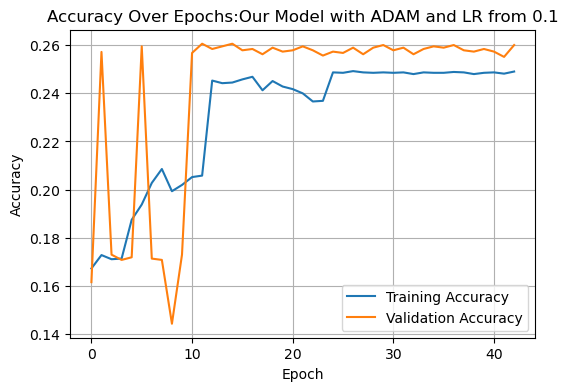

In [49]:
visualization_plots.plot_accuracy(metrics_accuracy, model_extra_desc="Our Model with ADAM and LR from 0.1")

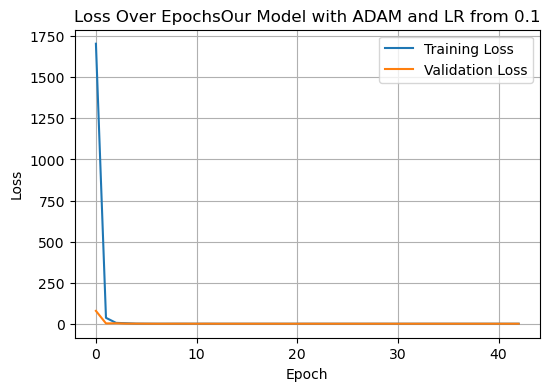

In [50]:
visualization_plots.plot_loss(metrics_loss, model_extra_desc="Our Model with ADAM and LR from 0.1")

#### Looking the Accuracy in each class of dataset

In [55]:
label_classes = training_set.class_to_idx
# Switch keys and values
label_classes = {value: key for key, value in label_classes.items()}
label_classes

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [56]:
class_correct = [0. for _ in range(params['num_classes'])]
total_correct = [0. for _ in range(params['num_classes'])]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        test = images
        outputs = cnn(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(params['num_classes']):
    if total_correct[i] > 0:  # Avoid division by zero
        accuracy = class_correct[i] * 100 / total_correct[i]
        print(f"Accuracy of {label_classes[i]}: {accuracy:.3f}%")
    else:
        print(f"Accuracy of {label_classes[i]}: No samples")

Accuracy of angry: 0.000%
Accuracy of disgust: 0.000%
Accuracy of fear: 0.000%
Accuracy of happy: 100.000%
Accuracy of neutral: 0.000%
Accuracy of sad: 0.000%
Accuracy of surprise: 0.000%
